# Text similarity using NLP

In this notebook, I wil be using various approaches to identify how similar two sentences are. I wil be using SICK dataset for this project. This dataset has two sentences along with the similariy score tagged by human. I will use correlation between my similarity scores and given similarity scores to assess the performance of the model.
Below the algorithms that I will use to calculate similarity:

1. Count Vectorizer + Cosine Similarity
2. TF-IDF Vectorizer + Cosine Similarity
3. Average Word2Vec + Cosine Similarity
4. Word2Vec + Word Mover Distance
5. Infersent algorithm for sentence encoding
6. Topic Modeling

In [1]:
import pyemd
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

In [11]:
def download_sick(f): 

    response = requests.get(f).text

    lines = response.split("\n")[1:]
    lines = [l.split("\t") for l in lines if len(l) > 0]
    lines = [l for l in lines if len(l) == 5]

    df = pd.DataFrame(lines, columns=["idx", "sent_1", "sent_2", "sim", "label"])
    df['sim'] = pd.to_numeric(df['sim'])
    return df
    
sick_train = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_train.txt")
sick_dev = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_trial.txt")
sick_test = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_test_annotated.txt")
sick_all = sick_train.append(sick_test).append(sick_dev)
sick_all = sick_all.reset_index()

In [12]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
def review_word_list(review):
    review_text = re.sub("[^a-zA-Z]"," ",review)
    review_text = re.sub(r'\W'," ",review_text)
    words= review_text.lower().split()
    words= [lemma.lemmatize(w,get_wordnet_pos(w)) for w in words if w not in set(stopwords.words('english')) and len(w)>1]
    document = ' '.join(words)
    return document

sick_all['sent_1_clean']=sick_all['sent_1'].apply(review_word_list)
sick_all['sent_2_clean']=sick_all['sent_2'].apply(review_word_list)

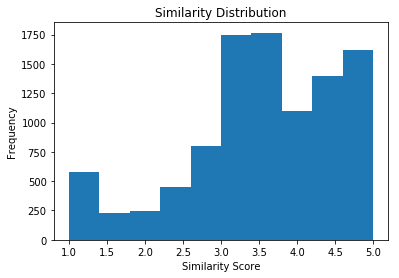

In [14]:
plt.hist(sick_all['sim'])
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Similarity Distribution")
plt.show()

In [15]:
sick_all[sick_all['sim']==1].head()

,idx,sent_1,sent_2,sim,label,sent_1_clean,sent_2_clean
505,1147,A woman is dipping a shrimp in batter,A man is driving a car,1.0,NEUTRAL,woman dip shrimp batter,man drive car
518,1180,A woman is boiling shrimps,There is no woman combing her hair,1.0,NEUTRAL,woman boil shrimp,woman comb hair
573,1317,A person is performing a card trick,A man is frying a tortilla,1.0,NEUTRAL,person perform card trick,man fry tortilla
622,1427,A woman is chopping an onion,A woman is washing her feet,1.0,NEUTRAL,woman chop onion,woman wash foot
636,1463,A man is exercising,A happy baby is laughing,1.0,NEUTRAL,man exercise,happy baby laugh


In [16]:
sick_all[sick_all['sim']==5].head()

,idx,sent_1,sent_2,sim,label,sent_1_clean,sent_2_clean
35,87,A lone biker is jumping in the air,"A biker is jumping in the air, alone",5.0,ENTAILMENT,lone biker jumping air,biker jumping air alone
253,603,A young lady with light brown hair is wearing ...,"A lady of young age, with light brown hair, is...",5.0,ENTAILMENT,young lady light brown hair wear red necklace ...,lady young age light brown hair wear red neckl...
294,692,A dog which is furry and black is in a backyar...,A dog which is furry and black is in a back ya...,5.0,ENTAILMENT,dog furry black backyard carry basket mouth,dog furry black back yard carry basket mouth
419,960,A man in a shirt dyed purple is looking at a m...,A man in a shirt dyed purple is looking at a m...,5.0,ENTAILMENT,man shirt dyed purple look man black shirt fun...,man shirt dyed purple look man black shirt fac...
431,989,The man and the boy are standing at the bottom...,A man and a boy are standing at the bottom of ...,5.0,ENTAILMENT,man boy stand bottom stair outdoors,man boy stand bottom stair outdoors


In [17]:
scaled_sim = (sick_all['sim']-sick_all['sim'].min())/(sick_all['sim'].max()-sick_all['sim'].min())

## Count Vectorizer method

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.8, stop_words=stopwords.words('english'))
vec = vectorizer.fit(pd.concat([sick_all['sent_1_clean'],sick_all['sent_2_clean']]))
X_sent1 = vec.transform(sick_all['sent_1_clean']).toarray()
X_sent2 = vec.transform(sick_all['sent_2_clean']).toarray()

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = np.diagonal(cosine_similarity(X_sent1,X_sent2))

In [20]:
x= np.corrcoef(similarity,scaled_sim.values)
sim_count_vec = x.diagonal(1)[0]
sim_count_vec

0.632846957479832

## TFIDF method

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.8, stop_words=stopwords.words('english'))
vec = vectorizer.fit(pd.concat([sick_all['sent_1_clean'],sick_all['sent_2_clean']]))
X_sent1 = vec.transform(sick_all['sent_1_clean']).toarray()
X_sent2 = vec.transform(sick_all['sent_2_clean']).toarray()

In [22]:
similarity = np.diagonal(cosine_similarity(X_sent1,X_sent2))
x= np.corrcoef(similarity,scaled_sim.values)
sim_tfidf_vec = x.diagonal(1)[0]
sim_tfidf_vec

0.625162814413102

## Word2Vec Embedding

In [87]:
import gensim
path='C:/Users/tomar/Google Drive/My folder 1/Courses/NLP/Quora Kaggle/embeddings/'
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format(path+'GoogleNews-vectors-negative300.bin', binary=True)  

In [100]:
sick_all['sent_1_token'] = sick_all['sent_1'].apply(lambda x: x.split())
sick_all['sent_2_token'] = sick_all['sent_2'].apply(lambda x: x.split())

sick_all['sent_1_clean_token'] = sick_all['sent_1_clean'].apply(lambda x: x.split())
sick_all['sent_2_clean_token'] = sick_all['sent_2_clean'].apply(lambda x: x.split())

In [101]:
def similarity_calc(sent1,sent2,model):
    tokens1 = [token for token in sent1 if token in model]
    tokens2 = [token for token in sent2 if token in model]
    if len(tokens1) == 0 or len(tokens2) == 0:
        return 0
    embedding1 = np.average([model[token] for token in tokens1], axis=0).reshape(1, -1)
    embedding2 = np.average([model[token] for token in tokens2], axis=0).reshape(1, -1)
    return cosine_similarity(embedding1, embedding2)

In [103]:
sim_cal = []
sim_cal_clean = []
for i in range(0,sick_all.shape[0]):
    sim_cal.append(similarity_calc(sick_all['sent_1_token'][i],sick_all['sent_2_token'][i],model)[0][0])
    sim_cal_clean.append(similarity_calc(sick_all['sent_1_clean_token'][i],sick_all['sent_2_clean_token'][i],model)[0][0])

In [108]:
x= np.corrcoef(sim_cal,scaled_sim.values)
sim_w2v = x.diagonal(1)[0]
print("Raw Senetence similarity is: {0:.4f}".format(sim_w2v))

x= np.corrcoef(sim_cal_clean,scaled_sim.values)
sim_w2v = x.diagonal(1)[0]
print("Clean Senetence similarity is: {0:.4f}".format(sim_w2v))

Raw Senetence similarity is: 0.6945
Clean Senetence similarity is: 0.7068


### Word mover distance

In [34]:
from pyemd import emd
from gensim.similarities import WmdSimilarity
sim_cal = []
for i in range(0,sick_all.shape[0]):
    sim_cal.append(-model.wmdistance(sick_all['sent_1_clean_token'][i],sick_all['sent_2_clean_token'][i]))
sim_cal = np.array(sim_cal)
sim_cal_scaled = (sim_cal-sim_cal.min())/(sim_cal.max()-sim_cal.min())

In [35]:
x= np.corrcoef(sim_cal_scaled,scaled_sim.values)
sim_w2v_wmd = x.diagonal(1)[0]
sim_w2v_wmd

0.6081976471082803

## Infersent

In [111]:
from models import InferSent
import torch

In [112]:
model_version = 1
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

In [113]:
# Keep it on CPU or put it on GPU
use_cuda = False
model = model.cuda() if use_cuda else model

In [114]:
W2V_PATH = 'C:/Users/tomar/Google Drive/My folder 1/Courses/NLP/Quora Kaggle/embeddings//glove.840B.300d.txt'
model.set_w2v_path(W2V_PATH)

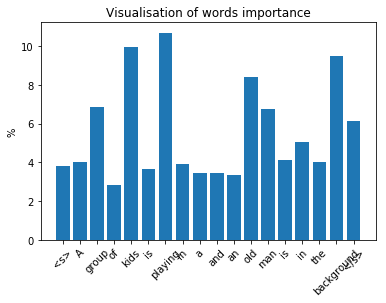

In [116]:
_, _ = model.visualize(sick_all['sent_1'][0])

In [122]:
raw_sentences1 = [x for x in sick_all['sent_1']]
raw_sentences2 = [x for x in sick_all['sent_2']]
model.build_vocab(raw_sentences1 + raw_sentences2, tokenize=True)

Found 2405(/2410) words with w2v vectors
Vocab size : 2405


In [123]:
embeddings1 = model.encode(raw_sentences1, tokenize=True)
embeddings2 = model.encode(raw_sentences2, tokenize=True)

In [124]:
inf_sims=[]
for (emb1, emb2) in zip(embeddings1, embeddings2):
    
    sim = cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]
    inf_sims.append(sim)

In [125]:
x= np.corrcoef(inf_sims,scaled_sim.values)
sim_inf = x.diagonal(1)[0]
sim_inf

0.7453382841664252

# Topic Modelling

In [136]:
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim
from spacy.lang.en import English
import warnings
warnings.filterwarnings('ignore')

In [133]:
text_data=list(sick_all['sent_1_clean_token'].values)+list(sick_all['sent_2_clean_token'].values)
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
coherence_values = []

In [141]:
range_num_topics = range(3,20)
for num_topics in range_num_topics:
    print(num_topics)
    model = gensim.models.LdaMulticore(corpus, num_topics = num_topics, id2word=dictionary, passes=15)
    coherencemodel = CoherenceModel(model=model, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


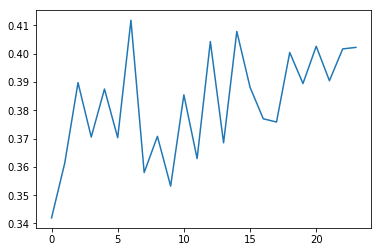

In [142]:
plt.plot(coherence_values)

In [194]:
max_topic = 3+coherence_values.index(max(coherence_values))
model = gensim.models.LdaMulticore(corpus, num_topics = max_topic, id2word=dictionary, passes=15)

In [195]:
for idx, topic in model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.140*"play" + 0.115*"man" + 0.067*"guitar" + 0.052*"boy" + 0.031*"cat" + 0.022*"jumping" + 0.020*"person" + 0.017*"piano" + 0.017*"sing" + 0.014*"little"
Topic: 1 
Words: 0.160*"dog" + 0.051*"run" + 0.043*"white" + 0.041*"brown" + 0.036*"play" + 0.034*"black" + 0.030*"ball" + 0.028*"two" + 0.026*"grass" + 0.024*"child"
Topic: 2 
Words: 0.128*"man" + 0.034*"sit" + 0.024*"play" + 0.019*"car" + 0.018*"walk" + 0.016*"stand" + 0.016*"people" + 0.014*"motorcycle" + 0.014*"two" + 0.014*"rope"
Topic: 3 
Words: 0.148*"woman" + 0.061*"girl" + 0.042*"man" + 0.041*"dance" + 0.024*"slice" + 0.023*"onion" + 0.016*"little" + 0.015*"cut" + 0.015*"egg" + 0.012*"sit"
Topic: 4 
Words: 0.070*"man" + 0.048*"water" + 0.031*"jumping" + 0.021*"trick" + 0.021*"dog" + 0.017*"woman" + 0.016*"perform" + 0.015*"pour" + 0.013*"oil" + 0.013*"kid"
Topic: 5 
Words: 0.055*"stand" + 0.045*"men" + 0.043*"people" + 0.037*"two" + 0.023*"front" + 0.022*"group" + 0.022*"rock" + 0.021*"child" + 0.021*"three"

In [196]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      15.778187        1       1 -0.284568 -0.024975
5      11.819218        1       2 -0.075340 -0.143194
8      11.377582        1       3  0.030028 -0.173831
7      11.224972        1       4  0.020943 -0.109215
0      10.697273        1       5  0.021409  0.244245
3      10.433746        1       6  0.202806 -0.048878
2       9.993098        1       7  0.001911  0.085735
6       9.687490        1       8  0.184785  0.040030
4       8.988430        1       9 -0.101974  0.130084, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
16    Default  2754.000000          dog  2754.000000  30.0000  30.0000
5     Default  2295.000000         play  2295.000000  29.0000  29.0000
48    Default  3056.000000        woman  3056.000000  28.0000  28.0000
3     Default  5357.000000          man  5357.000000  27.0000  27.0000
28    Default   853.000000          rid   853.000000  26.0000  26.0000
166   Default   700.000000       guitar   700.000000  25.0000  25.0000
70    Default  1206.000000         girl  1206.000000  24.0000  24.0000
223   Default   521.000000          men   521.000000  23.0000  23.0000
84    Default   968.000000          run   968.000000  22.0000  22.0000
67    Default  1036.000000         wear  1036.000000  21.0000  21.0000
503   Default   611.000000        slice   611.000000  20.0000  20.0000
140   Default   418.000000        dance   418.000000  19.0000  19.0000
128   Default  1049.000000        white  1049.000000  18.0000  18.0000
6     Default  1153.000000        stand  1153.000000  17.0000  17.0000
22    Default   745.000000        brown   745.000000  16.0000  16.0000
163   Default   931.000000        water   931.000000  15.0000  15.0000
158   Default   379.000000        horse   379.000000  14.0000  14.0000
217   Default   411.000000         bike   411.000000  13.0000  13.0000
44    Default   996.000000       people   996.000000  12.0000  12.0000
10    Default  1272.000000          boy  1272.000000  11.0000  11.0000
248   Default   341.000000          cat   341.000000  10.0000  10.0000
53    Default   842.000000          sit   842.000000   9.0000   9.0000
31    Default  1112.000000        black  1112.000000   8.0000   8.0000
35    Default   612.000000         ball   612.000000   7.0000   7.0000
504   Default   283.000000       potato   283.000000   6.0000   6.0000
30    Default  1222.000000       person  1222.000000   5.0000   5.0000
50    Default   774.000000      jumping   774.000000   4.0000   4.0000
55    Default   513.000000        shirt   513.000000   3.0000   3.0000
8     Default   781.000000        child   781.000000   2.0000   2.0000
97    Default   573.000000        grass   573.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
224    Topic9    76.829979        snowy    92.138489   2.2275  -4.7327
232    Topic9   139.812714      perform   190.489471   2.0999  -4.1340
809    Topic9    21.122343       silent    22.369452   2.3519  -6.0240
470    Topic9    49.675236  snowboarder    62.371361   2.1816  -5.1688
604    Topic9    86.858841          pot   126.983589   2.0295  -4.6100
163    Topic9   416.666473        water   931.060913   1.6052  -3.0420
76     Topic9    94.875664         pool   145.552765   1.9813  -4.5218
1004   Topic9    60.808254        strip    82.362236   2.1058  -4.9666
495    Topic9    45.951046          add    58.260193   2.1719  -5.2468
153    Topic9    45.714069         high    58.008286   2.1711  -5.2519
361    Topic9    97.164803         hill   161.141815   1.9034  -4.4979
321    Topic9    85.670227       across   143.740997   1.8917  -4.6238
207    Topic9    53.698986       pencil    75.690125   2.0660  -5.0909
50     Topic9   266.521179      jumping   774.738525   1.3422  -3.4889
469    Topic9    53.506229

In [197]:
def format_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    return sent_topics_df

In [198]:
dominant_topic = format_topics_sentences(model, corpus)

In [199]:
dominant_topic_1=dominant_topic.loc[:9926,:].reset_index().drop("index",axis=1)
dominant_topic_1.columns = ["1_"+x for x in dominant_topic_1.columns]
dominant_topic_2=dominant_topic.loc[9927:,:].reset_index().drop("index",axis=1)
dominant_topic_2.columns = ["2_"+x for x in dominant_topic_2.columns]

In [200]:
dominant_topic_all = pd.concat([sick_all[['sent_1','sent_2']],dominant_topic_1,dominant_topic_2],axis=1,ignore_index=True)
dominant_topic_all.columns = list(sick_all[['sent_1','sent_2']].columns) + list(dominant_topic_1.columns) + list(dominant_topic_2.columns)

In [236]:
lda_sim=[]
for i in range(sick_all.shape[0]):
    vec_bow1 = dictionary.doc2bow(sick_all['sent_1_clean_token'][i])
    vec_bow2 = dictionary.doc2bow(sick_all['sent_2_clean_token'][i])
    lda_sim.append(gensim.matutils.cossim(vec_bow1,vec_bow2))

In [237]:
x= np.corrcoef(lda_sim,scaled_sim.values)
sim_lda = x.diagonal(1)[0]
sim_lda

0.6316308827239399

# Results

It looks like Infersent sentence encoder is providing the best performance as it is able to undersatnd the overall meaning and structure of the sentence well. Below is the summary of the results:


1. Count Vectorizer + Cosine Similarity: **Correlation Score: 0.6328**
2. TF-IDF Vectorizer + Cosine Similarity: **Correlation Score: 0.6251**
3. Average Word2Vec + Cosine Similarity: **Correlation Score: 0.7068**
4. Word2Vec + Word Mover Distance: **Correlation Score: 0.6081**
5. Infersent algorithm for sentence encoding: **Correlation Score: 0.7453**
6. Topic Modeling: **Correlation Score: 0.6316**